In [14]:
words = open('names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
len(words)

32033

In [11]:
b = {}
for w in words[:3]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [13]:
sorted(b.items(), key = lambda kv : -kv[1])

[(('a', '<E>'), 3),
 (('<S>', 'e'), 1),
 (('e', 'm'), 1),
 (('m', 'm'), 1),
 (('m', 'a'), 1),
 (('<S>', 'o'), 1),
 (('o', 'l'), 1),
 (('l', 'i'), 1),
 (('i', 'v'), 1),
 (('v', 'i'), 1),
 (('i', 'a'), 1),
 (('<S>', 'a'), 1),
 (('a', 'v'), 1),
 (('v', 'a'), 1)]

In [48]:
import torch
N = torch.zeros((27,27), dtype = torch.int32)

In [104]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [50]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

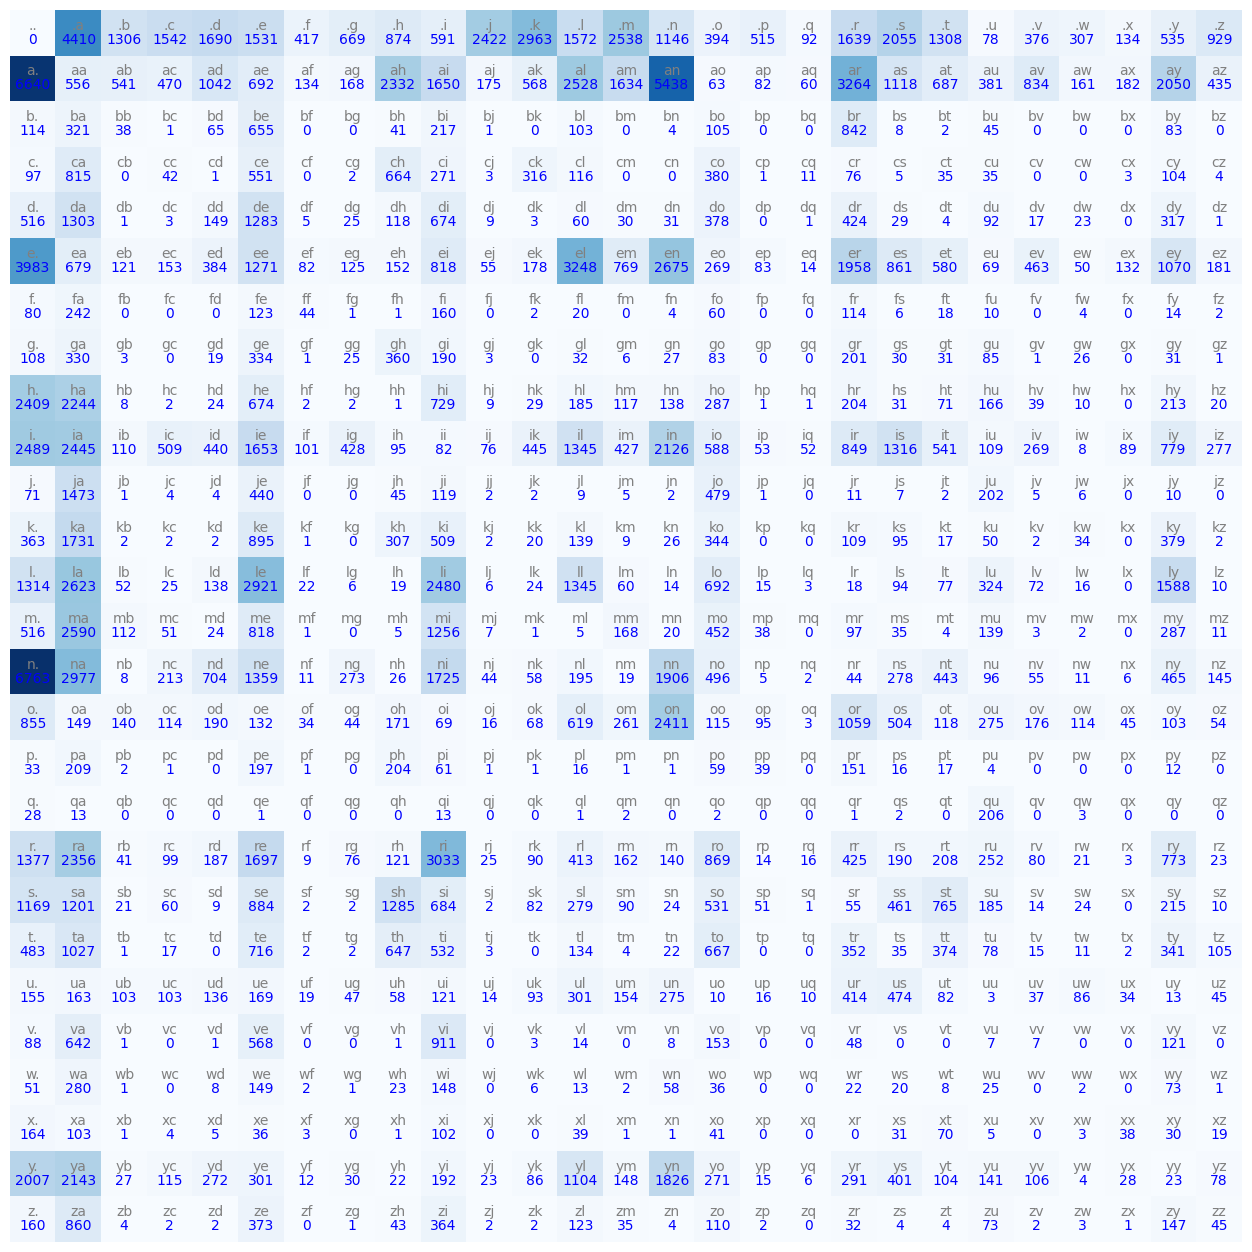

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(N)

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va = "bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va = "top", color="blue")
plt.axis('off')

In [56]:
#I have the occurences of each group of characters
#so basically I have a count of how frequently a character follows another character
#So now if I make this into a probability distribution, I get the probabilities of a character following another character
#to make it into a probability distribution, I can simply normalize the frequency vector by dividing by the sum of frequencies.

p = N[0].float()
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [105]:
#cool way to sample from the probability distribution
#using a generator with manual seed for consistent sampling.

g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1000, replacement=True, generator=g)

#ix samples the indices based on their distribution.
#So as I generate more samples, it matches the distribution more.
b = {}

for i in ix:
    b[itos[i.item()]] = b.get(itos[i.item()], 0) + 1
b

{'e': 100,
 'm': 15,
 'i': 99,
 '.': 307,
 'r': 29,
 'a': 299,
 'u': 21,
 'o': 36,
 'y': 20,
 'l': 30,
 's': 3,
 'v': 3,
 'n': 16,
 'd': 2,
 'k': 5,
 'z': 2,
 't': 5,
 'b': 2,
 'j': 2,
 'w': 4}

In [170]:
g = torch.Generator().manual_seed(2147483647)
ix=0

for i in range(5):
    out = []
    while True:
        p = N[ix].float()
        p /= p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
        out.append(itos[ix.item()])
        if(ix.item()==0):
            break
        ix = ix.item()

    print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [164]:
# Moving to a neural net paradigm
# The table of frequency counts that I have that was then converted into a probability distribution
# is like an intuitive way to imagine model parameters. The weights being the frequencies which become the probabilities
# So now we need to be able to start out with random parameters and tune them via training(Gradient based optimization).
# To do so, we need an estimate of how good the model's predictions are.
# We use the likelihood as an estimate. This is nothing but the product of all the probabilities.
# The likelihood tells you how likely that string was to be generated.
# We can find the negative log likelihood and use that as a loss function since minimizing that would mean that the 
# model is predicting outputs closer to the labels.


#Creating the training set of bigrams (x,y)

xs, ys = [], []

for w in words:
    chs = (['.']) + list(w) + (['.'])
    for ch1, ch2 in zip(chs, chs[1:]):
        ix = stoi[ch1]
        ix1 = stoi[ch2]
        xs.append(ix)
        ys.append(ix1)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
nums = xs.nelement()
xs.shape

torch.Size([228146])

In [165]:
#Now to feed these tensors into a neural net, we use one-hot encoding.(Cause they are indices)

import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc.shape

torch.Size([228146, 27])

In [166]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

for i in range(100):
    #forward pass
    logits = xenc @ W # nums, 27
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    #negative log likeihood (classification)
    loss = -probs[torch.arange(nums), ys].log().mean() + 0.01*(W**2).mean() #Regularization
    print(loss.item())

    #Backward pass
    W.grad=None #set gradients to 0 initially
    loss.backward()

    #update weights
    W.data += -50*W.grad


3.7686190605163574
3.3788068294525146
3.161090850830078
3.027186155319214
2.9344842433929443
2.8672313690185547
2.816654682159424
2.777146577835083
2.745253801345825
2.7188303470611572
2.696505546569824
2.6773719787597656
2.6608052253723145
2.6463515758514404
2.633665084838867
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886809825897217
2.582256317138672
2.5764293670654297
2.5711238384246826
2.566272735595703
2.5618226528167725
2.5577263832092285
2.5539441108703613
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413525104522705
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.5297679901123047
2.527860164642334
2.5260636806488037
2.5243709087371826
2.522773265838623
2.521263837814331
2.519836664199829
2.5184857845306396
2.5172057151794434
2.515990734100342
2.5148372650146484
2.5137410163879395
2.512697696685791
2.511704444885254
2.5107581615448
2.509855031967163
2.5089924335479736
2.5081686973571777
2.507380485534668
2

In [174]:
#Sampling from the neural net model

#Now that the model is trained basically the W's are adjusted to transform the inputs 
#to give the outputs such that the probabilities assigned are higher according to the training data.
#This should result in more training-data like outputs when we sample from the distribution.

g = torch.Generator().manual_seed(2147483647)

for i in range(5):

    ix=0
    out=[]
    
    while True:
    
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        #p is a 1, 27 matrix containing the probability distribution of the next character.
        #We can just sample from this distribution to generate the next character.
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix==0: # We predicted a full stop
            break

    print(''.join(out))

junide.
janasah.
p.
cfay.
a.
